## Compare ChebyKAN's ability in function interpolation with MLP

In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
# from ChebyKANLayer import ChebyKANLayer
from layers.kan_feedforward import FeedForward, KANLinear

In [23]:
# Define target function
def target_function(x):
    y = np.zeros_like(x)
    mask1 = x < 0.5
    y[mask1] = np.sin(20 * np.pi * x[mask1]) + x[mask1] ** 2
    mask2 = (0.5 <= x) & (x < 1.5)
    y[mask2] = 0.5 * x[mask2] * np.exp(-x[mask2]) + np.abs(np.sin(5 * np.pi * x[mask2]))
    mask3 = x >= 1.5
    y[mask3] = np.log(x[mask3] - 1) / np.log(2) - np.cos(2 * np.pi * x[mask3])

    # add noise
    noise = np.random.normal(0, 0.2, y.shape)
    y += noise
    
    return y

In [11]:
# Define MLP and ChebyKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        return self.layers(x-1) # centralize the input


# class ChebyKAN(nn.Module):
#     def __init__(self):
#         super(ChebyKAN, self).__init__()
#         self.chebykan1 = ChebyKANLayer(1, 8, 8)
#         self.chebykan2 = ChebyKANLayer(8, 1, 8)

#     def forward(self, x):
#         x = self.chebykan1(x)
#         x = self.chebykan2(x)
#         return x

# class KANSum(nn.Module):
#     def __init__(self, ) -> None:
#         super().__init__()
#         self.kan = KANLinear(1, 1)
#     def forward(self, x):
#         x = self.kan(x)
#         x = torch.sum(x)
#         return x

In [25]:
# Generate sample data
x_train = torch.linspace(0, 2, steps=500).unsqueeze(1)
y_train = torch.tensor(target_function(x_train))

# Instantiate models
cheby_model =  FeedForward(1, 16, activation=None)  #FeedForward(1, 16)
mlp_model = SimpleMLP()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer_cheby = torch.optim.Adam(cheby_model.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.03)

cheby_losses = []
mlp_losses = []

# Train the models
epochs = 200000
for epoch in range(epochs):
    optimizer_cheby.zero_grad()
    outputs_cheby = cheby_model(x_train)
    loss_cheby = criterion(outputs_cheby, y_train)
    loss_cheby.backward()
    optimizer_cheby.step()

    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train)
    loss_mlp = criterion(outputs_mlp, y_train)
    loss_mlp.backward()
    optimizer_mlp.step()

    if epoch % 100 == 0:
        cheby_losses.append(loss_cheby.item())
        mlp_losses.append(loss_mlp.item())
        print(f'Epoch {epoch + 1}/{epochs}, ChebyKAN Loss: {loss_cheby.item():.4f}, MLP Loss: {loss_mlp.item():.4f}')

# Test the models
x_test = torch.linspace(0, 2, steps=400).unsqueeze(1)
y_pred_cheby = cheby_model(x_test).detach()
y_pred_mlp = mlp_model(x_test).detach()

Epoch 1/200000, ChebyKAN Loss: 0.6612, MLP Loss: 0.5102
Epoch 101/200000, ChebyKAN Loss: 0.2195, MLP Loss: 0.2360
Epoch 201/200000, ChebyKAN Loss: 0.2174, MLP Loss: 0.2341
Epoch 301/200000, ChebyKAN Loss: 0.1949, MLP Loss: 0.2333
Epoch 401/200000, ChebyKAN Loss: 0.1491, MLP Loss: 0.2327
Epoch 501/200000, ChebyKAN Loss: 0.1143, MLP Loss: 0.2318
Epoch 601/200000, ChebyKAN Loss: 0.0863, MLP Loss: 0.2298
Epoch 701/200000, ChebyKAN Loss: 0.0758, MLP Loss: 0.2256
Epoch 801/200000, ChebyKAN Loss: 0.0648, MLP Loss: 0.2222
Epoch 901/200000, ChebyKAN Loss: 0.0602, MLP Loss: 0.2213
Epoch 1001/200000, ChebyKAN Loss: 0.0545, MLP Loss: 0.2209
Epoch 1101/200000, ChebyKAN Loss: 0.0525, MLP Loss: 0.2208
Epoch 1201/200000, ChebyKAN Loss: 0.0505, MLP Loss: 0.2206
Epoch 1301/200000, ChebyKAN Loss: 0.0490, MLP Loss: 0.2206
Epoch 1401/200000, ChebyKAN Loss: 0.0489, MLP Loss: 0.2205
Epoch 1501/200000, ChebyKAN Loss: 0.0458, MLP Loss: 0.2204
Epoch 1601/200000, ChebyKAN Loss: 0.0442, MLP Loss: 0.2245
Epoch 170

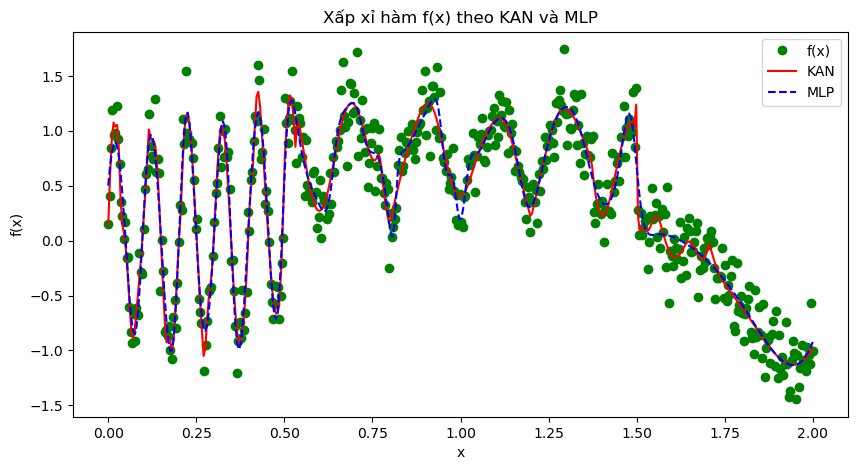

In [26]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_train.numpy(), y_train.numpy(), 'go', label='f(x)')
plt.plot(x_test.numpy(), y_pred_cheby.numpy(), 'r-', label='KAN')
plt.plot(x_test.numpy(), y_pred_mlp.numpy(), 'b--', label='MLP')
plt.title('Xấp xỉ hàm f(x) theo KAN và MLP')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

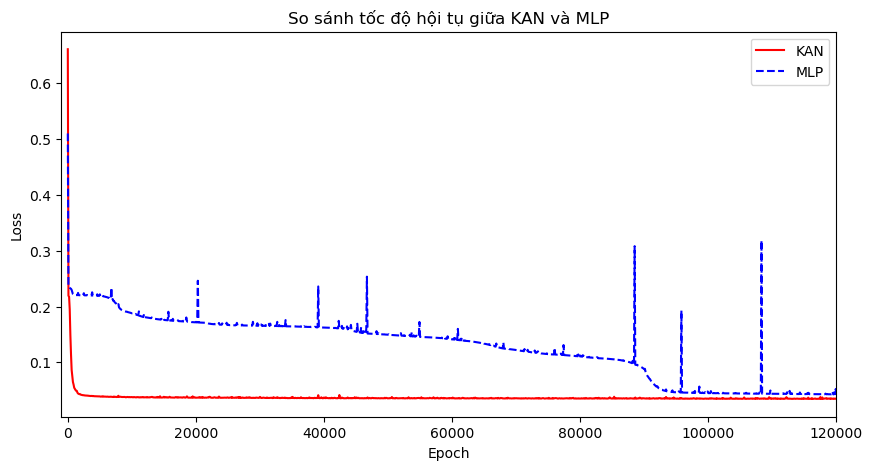

In [27]:
# Plot the convergence speed
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(0, epochs, 100), cheby_losses, 'r-', label='KAN')
plt.plot(range(0, epochs, 100), mlp_losses, 'b--', label='MLP')
plt.title('So sánh tốc độ hội tụ giữa KAN và MLP')
plt.xlim(-1000, 120000)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()